# Assigment I

In [1]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

from HANCModel import HANCModelClass

## Setup

In [2]:
model = HANCModelClass(name='baseline') # create an instance of the model
par = model.par
ss = model.ss

production_firm: [Gamma,K,phi0,phi1,L0,L1] -> [rK,w0,w1,Y]
hh: [Gamma,phi0,phi1,rK,w0,w1] -> [A_hh,C_hh,U_hh,L0_hh,L1_hh]
market_clearing: [A_hh,L0,L0_hh,L1,L1_hh,Y,C_hh,K] -> [A,I,clearing_A,clearing_L0,clearing_L1,clearing_Y]


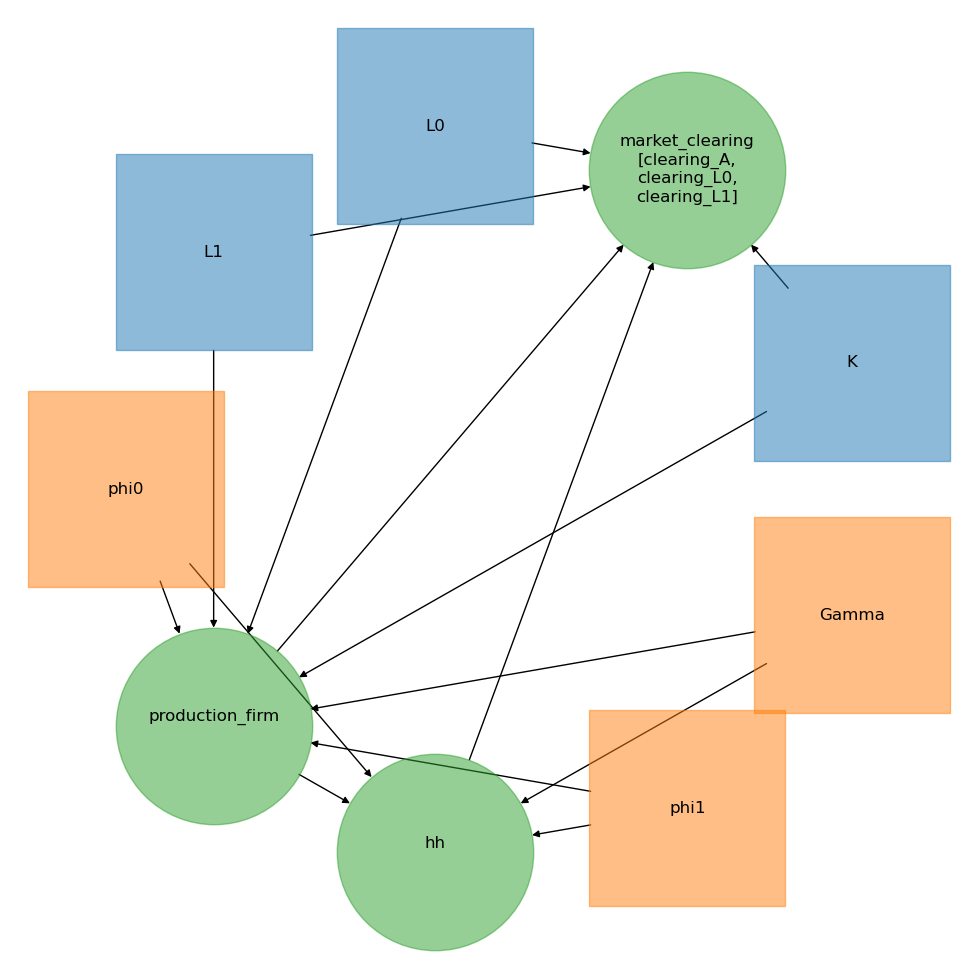

In [3]:
model.info(only_blocks=True)
model.draw_DAG(figsize=(10,10))

### Test of Household Problem

In [4]:
ss.phi0 = 1.0
ss.phi1 = 2.0
ss.rK = 0.01
ss.w0 = 1.0
ss.w1 = 1.0
ss.Gamma = 1.0

model.solve_hh_ss(do_print=True)
model.simulate_hh_ss(do_print=True)

household problem in ss solved in 0.1 secs [52 iterations]
household problem in ss simulated in 1.0 secs [2 iterations]


## Find stationary equilibrium

Find stationary equilibrium:

In [5]:
model.find_ss(method='direct',do_print=True)

### step 1: broad search ###

guess ss.K = 1.0000
implied ss.rK = 0.2777
implied ss.w0 = 0.3703
implied ss.w1 = 0.3703
household problem in ss solved in 0.3 secs [318 iterations]
household problem in ss simulated in 0.0 secs [94 iterations]
implied ss.A_hh = 198.5944
clearing_A = -197.59444763

guess ss.K = 2.0000
implied ss.rK = 0.1782
implied ss.w0 = 0.4752
implied ss.w1 = 0.4752
household problem in ss solved in 0.6 secs [601 iterations]
household problem in ss simulated in 0.0 secs [333 iterations]
implied ss.A_hh = 243.8378
clearing_A = -241.83775570

guess ss.K = 3.0000
implied ss.rK = 0.1375
implied ss.w0 = 0.5499
implied ss.w1 = 0.5499
household problem in ss solved in 1.0 secs [1008 iterations]
household problem in ss simulated in 1.1 secs [12834 iterations]
implied ss.A_hh = 276.5831
clearing_A = -273.58311581

guess ss.K = 4.0000
implied ss.rK = 0.1144
implied ss.w0 = 0.6099
implied ss.w1 = 0.6099
household problem in ss solved in 1.7 secs [1687 iterations]
household problem

In [6]:
for varname in model.varlist:
    print(f'{varname:15s}: {ss.__dict__[varname]:.4f}')

Gamma          : 1.0000
K              : 4.1097
phi0           : 1.0000
phi1           : 2.0000
L0             : 0.6667
L1             : 0.6667
rK             : 0.1124
w0             : 0.6159
w1             : 0.6159
Y              : 1.2831
A_hh           : 4.1097
C_hh           : 0.8722
U_hh           : -1.8721
L0_hh          : 0.6667
L1_hh          : 0.6667
A              : 4.1097
I              : 0.4110
clearing_A     : 0.0000
clearing_L0    : 0.0000
clearing_L1    : 0.0000
clearing_Y     : 0.0000


### Examining stationary equilibrium

Plot of household behavior for different values of $\beta$ and $z$.

In [7]:
model.test_path()

shocks: phi0 phi1 Gamma 
unknowns: K L0 L1 

look at max(abs(path.VARNAME[:]-ss.VARNAME)):

 blocks.production_firm
  rK               0.0e+00
  w0               0.0e+00
  w1               0.0e+00
  Y                0.0e+00
 hh
  A_hh             1.8e-07
  C_hh             3.2e-09
  U_hh             5.4e-01
  L0_hh            2.1e-15
  L1_hh            2.0e-15
 blocks.market_clearing
  A                0.0e+00
  I                0.0e+00
  clearing_A       1.8e-07 [target]
  clearing_L0      2.0e-14 [target]
  clearing_L1      2.0e-14 [target]
  clearing_Y       3.2e-09


note: inputs = steady state value -> expected: constant value (straigt line) in roughly -10^-5 to 10^5

household problem solved along transition path in 0.6 secs
household problem simulated along transition in 0.1 secs



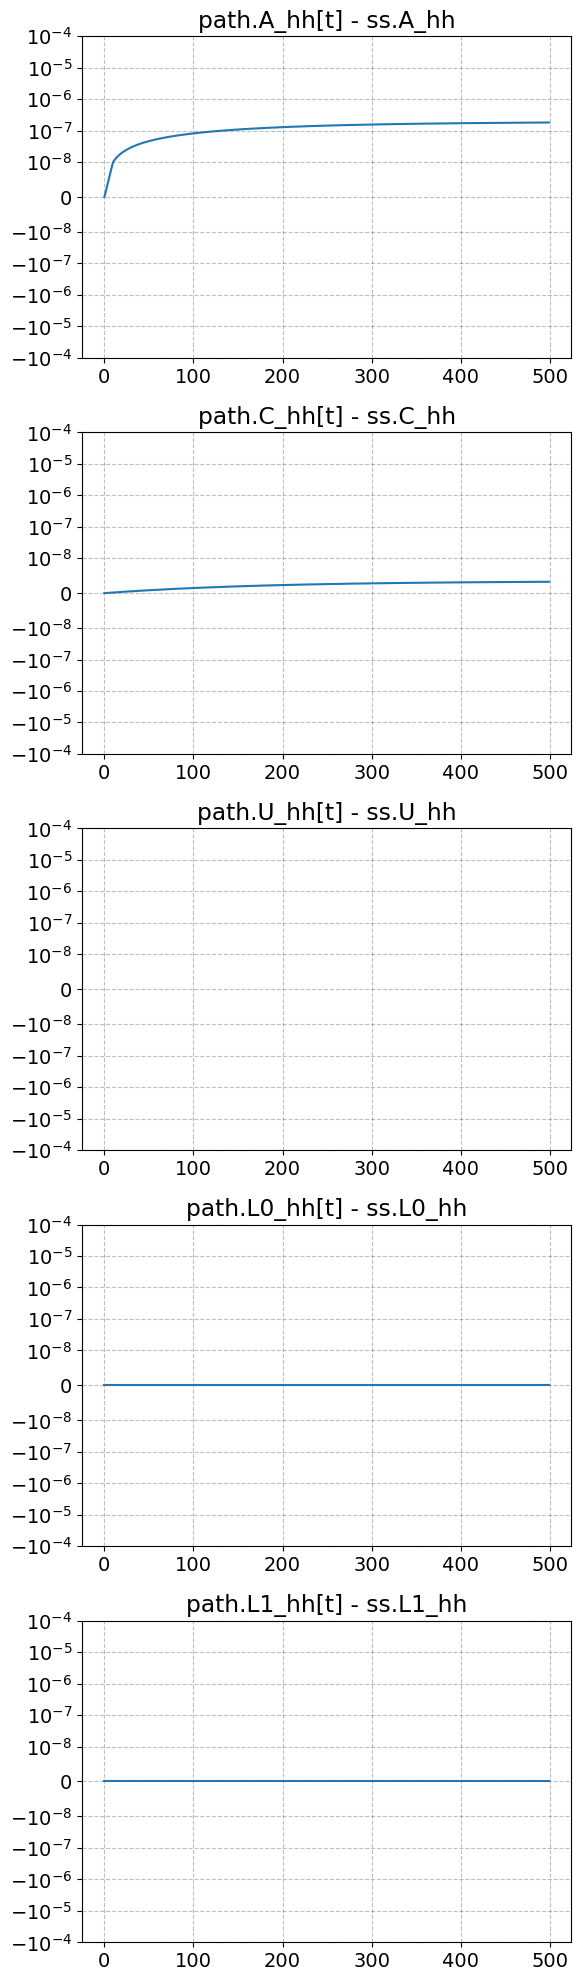

In [8]:
model.test_hh_path()

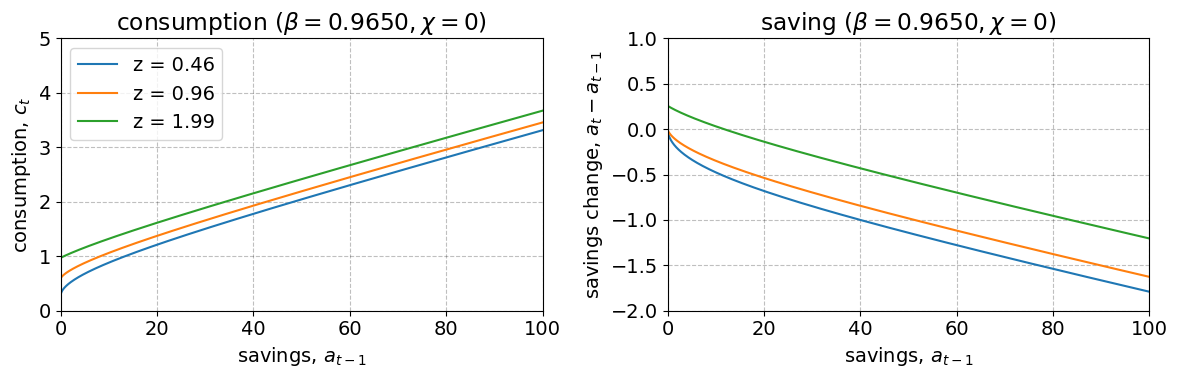

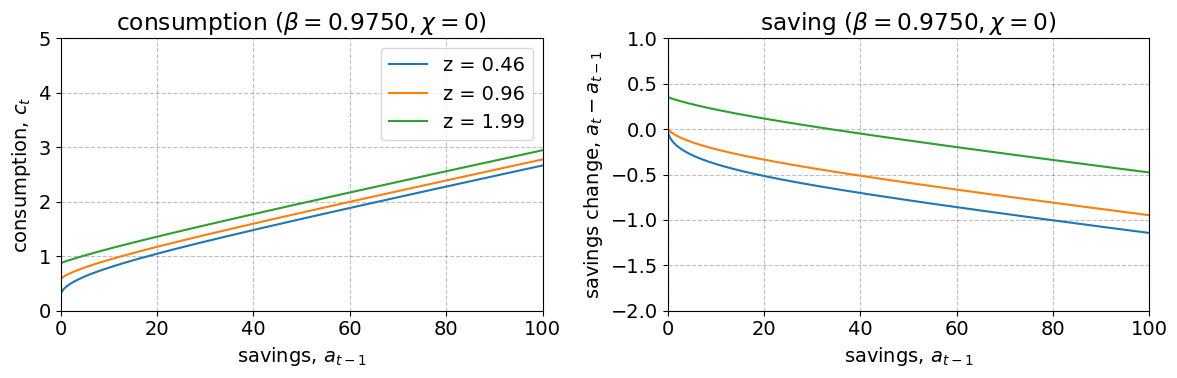

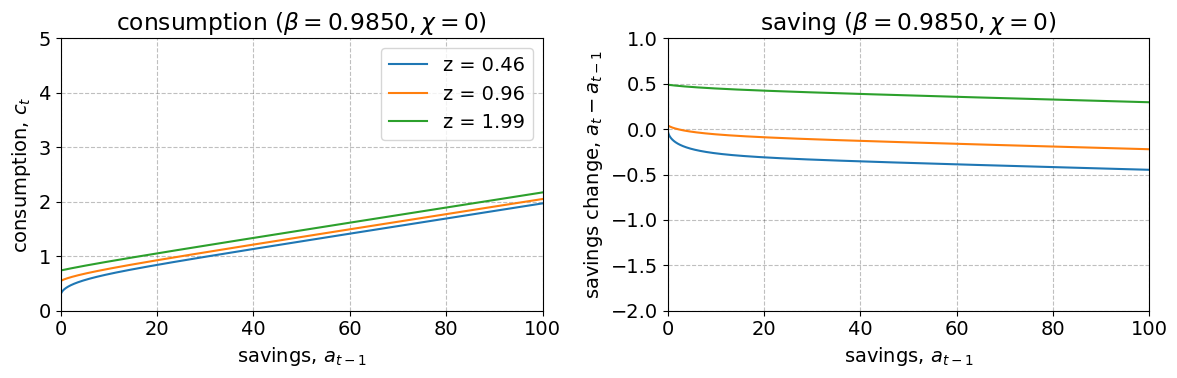

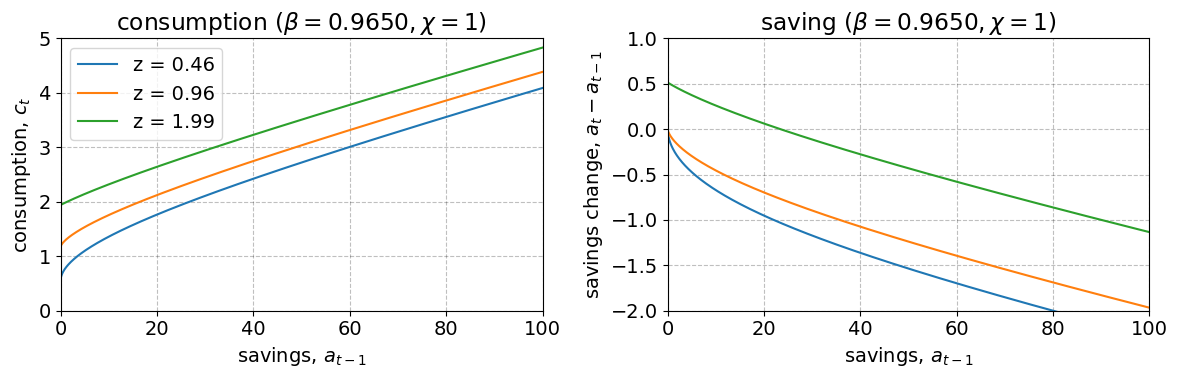

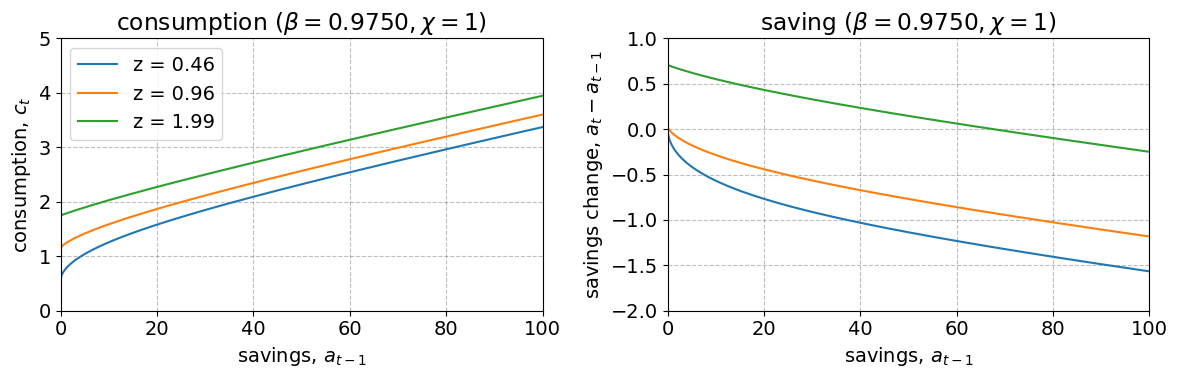

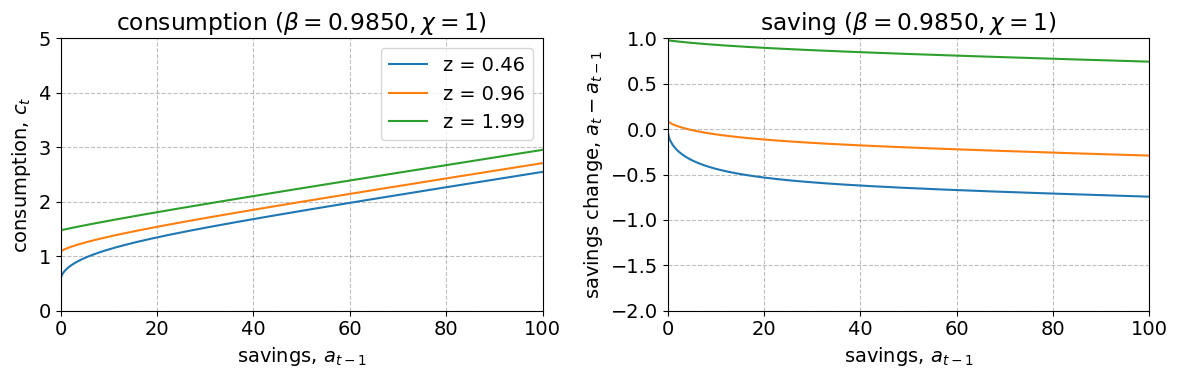

In [9]:
for i_beta,beta in enumerate(par.beta_grid[:len(par.beta_grid)]):
    fig = plt.figure(figsize=(12,4),dpi=100)

    I = par.a_grid < 500

    # a. consumption
    ax = fig.add_subplot(1,2,1)
    ax.set_title(f'consumption ($\\beta = {beta:.4f}, \\chi = {par.eta1_grid[i_beta]:.0f}$)')

    for i_z,z in enumerate(par.z_grid):
        if i_z%3 == 0 or i_z == par.Nz-1:
            ax.plot(par.a_grid[I],ss.c[i_beta,i_z,I],label=f'z = {z:.2f}')

    ax.legend(frameon=True)
    ax.set_xlabel('savings, $a_{t-1}$')
    ax.set_ylabel('consumption, $c_t$')
    ax.set_xlim(0,100)
    ax.set_ylim(0,5)

    # b. saving
    ax = fig.add_subplot(1,2,2)
    ax.set_title(f'saving ($\\beta = {beta:.4f}, \\chi = {par.eta1_grid[i_beta]:.0f}$)')

    for i_z,z in enumerate(par.z_grid):
        if i_z%3 == 0 or i_z == par.Nz-1:
            ax.plot(par.a_grid[I],ss.a[i_beta,i_z,I]-par.a_grid[I],label=f'z = {z:.2f}')

    ax.set_xlabel('savings, $a_{t-1}$')
    ax.set_ylabel('savings change, $a_{t}-a_{t-1}$')
    ax.set_xlim(0,100)
    ax.set_ylim(-2,1)

    fig.tight_layout()
    fig.savefig(f'figs/fig_{i_beta}.png',dpi=200)

### Distributions

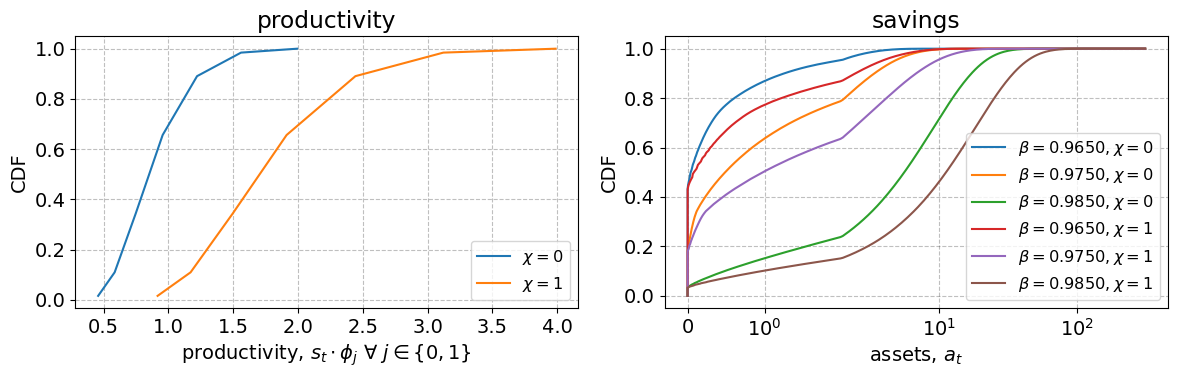

In [10]:
fig = plt.figure(figsize=(12,4),dpi=100)

# a. income
ax = fig.add_subplot(1,2,1)
ax.set_title('productivity')
for i_beta,beta in enumerate(par.beta_grid):
    if i_beta in [1,2,4,5]:
        continue
    elif i_beta in [0]:
        cumsum = np.cumsum(np.sum(ss.D[i_beta],axis=1))
        ax.plot(par.z_grid*ss.phi0, cumsum/cumsum[-1], label=f'$\\chi = {par.eta1_grid[i_beta]:.0f}$')
    else:
        cumsum = np.cumsum(np.sum(ss.D[i_beta],axis=1))
        ax.plot(par.z_grid*ss.phi1, cumsum/cumsum[-1], label=f'$\\chi = {par.eta1_grid[i_beta]:.0f}$')
ax.set_xlabel('productivity, $s_{t} \cdot \phi_{j} \ \\forall \ j\in \{0,1\}$')
ax.set_ylabel('CDF')
ax.legend(loc = 'lower right', fontsize = 'small')

# b. assets
ax = fig.add_subplot(1,2,2)
ax.set_title('savings')
for i_beta in range(par.Nfix):
    cumsum = np.cumsum(np.sum(ss.D[i_beta],axis=0))
    ax.plot(np.insert(par.a_grid,0,par.a_grid[0]), np.insert(cumsum/cumsum[-1],0,0.0), label=f'$\\beta = {par.beta_grid[i_beta]:.4f}, \\chi = {par.eta1_grid[i_beta]:.0f}$')
ax.set_xlabel('assets, $a_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')
ax.legend(loc = 'lower right', fontsize = 'small')

fig.tight_layout()
fig.savefig(f'figs/prod+asset_dist.png')

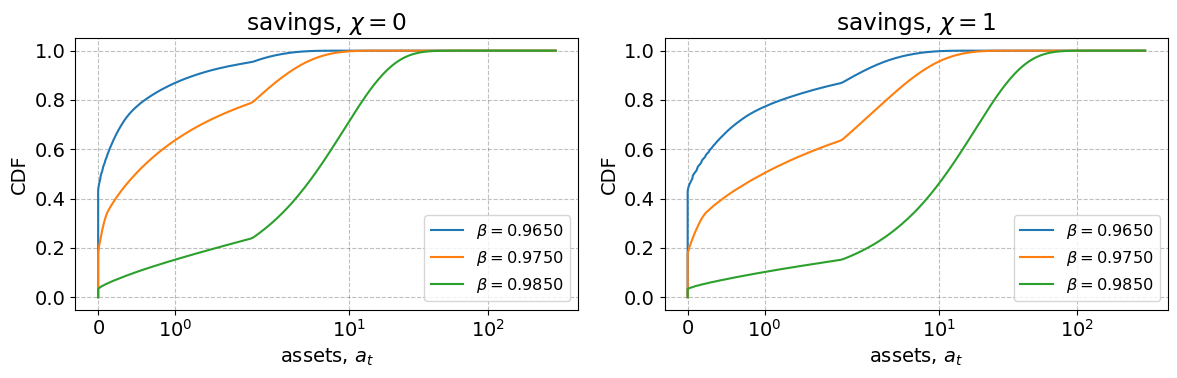

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4),dpi=100)

# b. assets
axs[0].set_title('savings, $\\chi = 0$')
axs[1].set_title('savings, $\\chi = 1$')

for i_beta in range(par.Nfix):
    if par.eta1_grid[i_beta] == 0:
        cumsum = np.cumsum(np.sum(ss.D[i_beta],axis=0))
        axs[0].plot(np.insert(par.a_grid,0,par.a_grid[0]),np.insert(cumsum/cumsum[-1],0,0.0),label=f'$\\beta = {par.beta_grid[i_beta]:.4f}$')
    elif par.eta1_grid[i_beta] == 1:
        cumsum = np.cumsum(np.sum(ss.D[i_beta],axis=0))
        axs[1].plot(np.insert(par.a_grid,0,par.a_grid[0]),np.insert(cumsum/cumsum[-1],0,0.0),label=f'$\\beta = {par.beta_grid[i_beta]:.4f}$')

for ax in axs:
    ax.set_xlabel('assets, $a_{t}$')
    ax.set_ylabel('CDF')
    ax.set_xscale('symlog')
    ax.legend(loc = 'lower right', fontsize = 'small')

plt.tight_layout()
plt.show()
fig.savefig(f'figs/asset_dist.png')

## Varying productivity

### Find Jacobians

**Jacobians:**

In [12]:
model.compute_jacs(do_print=True)

household Jacobians:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for Gamma           in 0.9 secs
curly_Y and curly_D calculated for phi0            in 0.8 secs
curly_Y and curly_D calculated for phi1            in 0.8 secs
curly_Y and curly_D calculated for rK              in 0.9 secs
curly_Y and curly_D calculated for w0              in 0.8 secs
curly_Y and curly_D calculated for w1              in 0.8 secs
curly_E calculated in 0.8 secs
builiding blocks combined in 2.9 secs
household Jacobian computed in 8.6 secs

full Jacobians:
full Jacobian to unknowns computed in 0.9 secs [in evaluate_blocks(): 0.5 secs]
full Jacobian to shocks computed in 0.8 secs [in evaluate_blocks(): 0.5 secs]


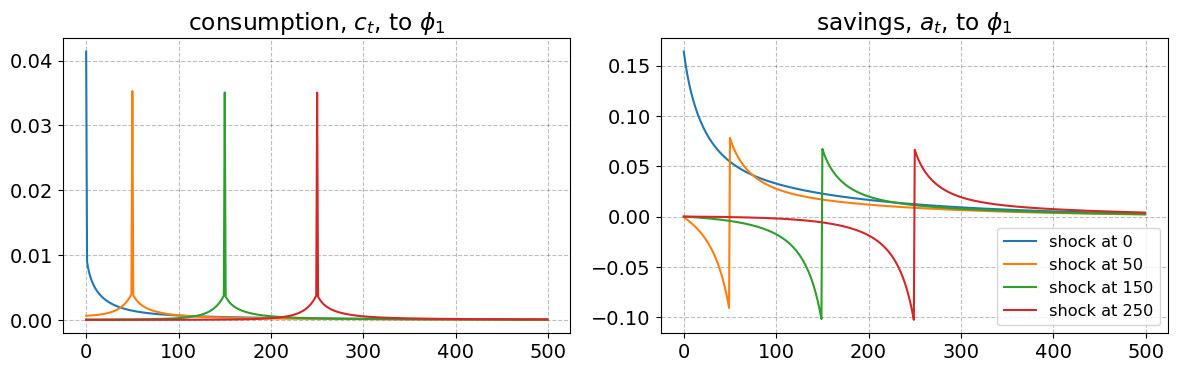

In [13]:
fig = plt.figure(figsize=(12,14),dpi=100)

i = 0
for varname in ['phi1']:  
    # a. consumption
    i += 1    
    ax = fig.add_subplot(4, 2, i)
    ax.set_title(f'consumption, $c_t$, to $\phi_1$')
    for s in [0, 50, 150, 250]:
        jac_hh_var = model.jac_hh[('C_hh', varname)]
        ax.plot(np.arange(par.T), jac_hh_var[:, s], label=f'shock at {s}')
    
    # b. savings
    i += 1    
    ax = fig.add_subplot(4, 2, i)
    ax.set_title(f'savings, $a_t$, to $\phi_1$')
    for s in [0, 50, 150, 250]:
        jac_hh_var = model.jac_hh[('A_hh', varname)]
        ax.plot(np.arange(par.T), jac_hh_var[:, s], label=f'shock at {s}')
    if i == 2:
        ax.legend(loc = 'lower right', fontsize = 'small')

# save fig
fig.tight_layout()
fig.savefig(f'figs/jacobian.png')


### Find transition path

In [14]:
# a. define shock
dphi1 = np.zeros(par.T)
dphi1[0:9] = 0.1*ss.phi1
shocks = {'dphi1':dphi1} 

# b. find transition path
model.find_transition_path(do_print=True,shocks=shocks)

finding the transition path:
 it =   0 -> max. abs. error = 2.91e-01
   2.91e-01 in clearing_A
   2.44e-14 in clearing_L0
   6.67e-02 in clearing_L1
 it =   1 -> max. abs. error = 4.59e-03
   4.59e-03 in clearing_A
   2.22e-16 in clearing_L0
   7.44e-15 in clearing_L1
 it =   2 -> max. abs. error = 1.18e-04
   1.18e-04 in clearing_A
   3.33e-16 in clearing_L0
   2.22e-16 in clearing_L1
 it =   3 -> max. abs. error = 7.46e-07
   7.46e-07 in clearing_A
   3.33e-16 in clearing_L0
   4.44e-16 in clearing_L1
 it =   4 -> max. abs. error = 3.80e-09
   3.80e-09 in clearing_A
   3.33e-16 in clearing_L0
   5.55e-16 in clearing_L1
 it =   5 -> max. abs. error = 9.58e-12
   9.58e-12 in clearing_A
   2.22e-16 in clearing_L0
   4.44e-16 in clearing_L1

transition path found in 5.5 secs


### shocks ###


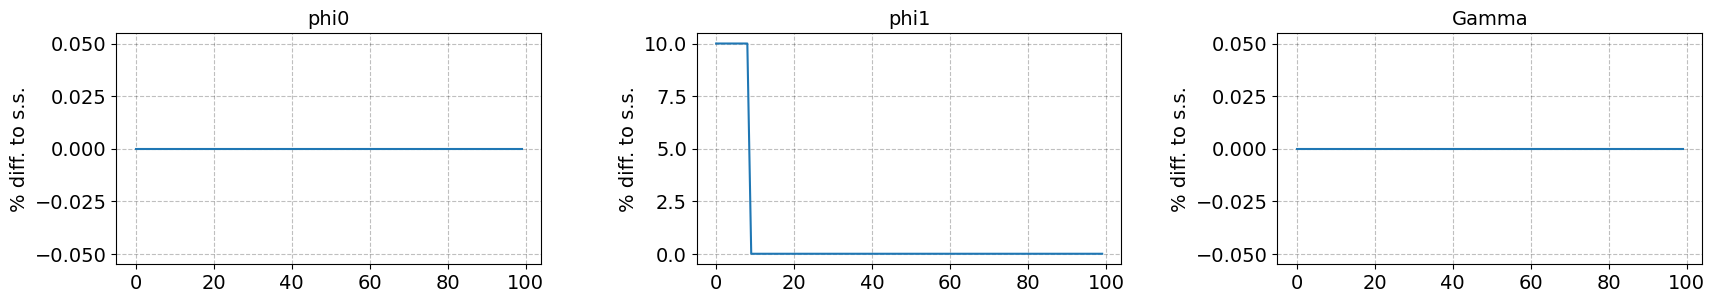


### varnames ###


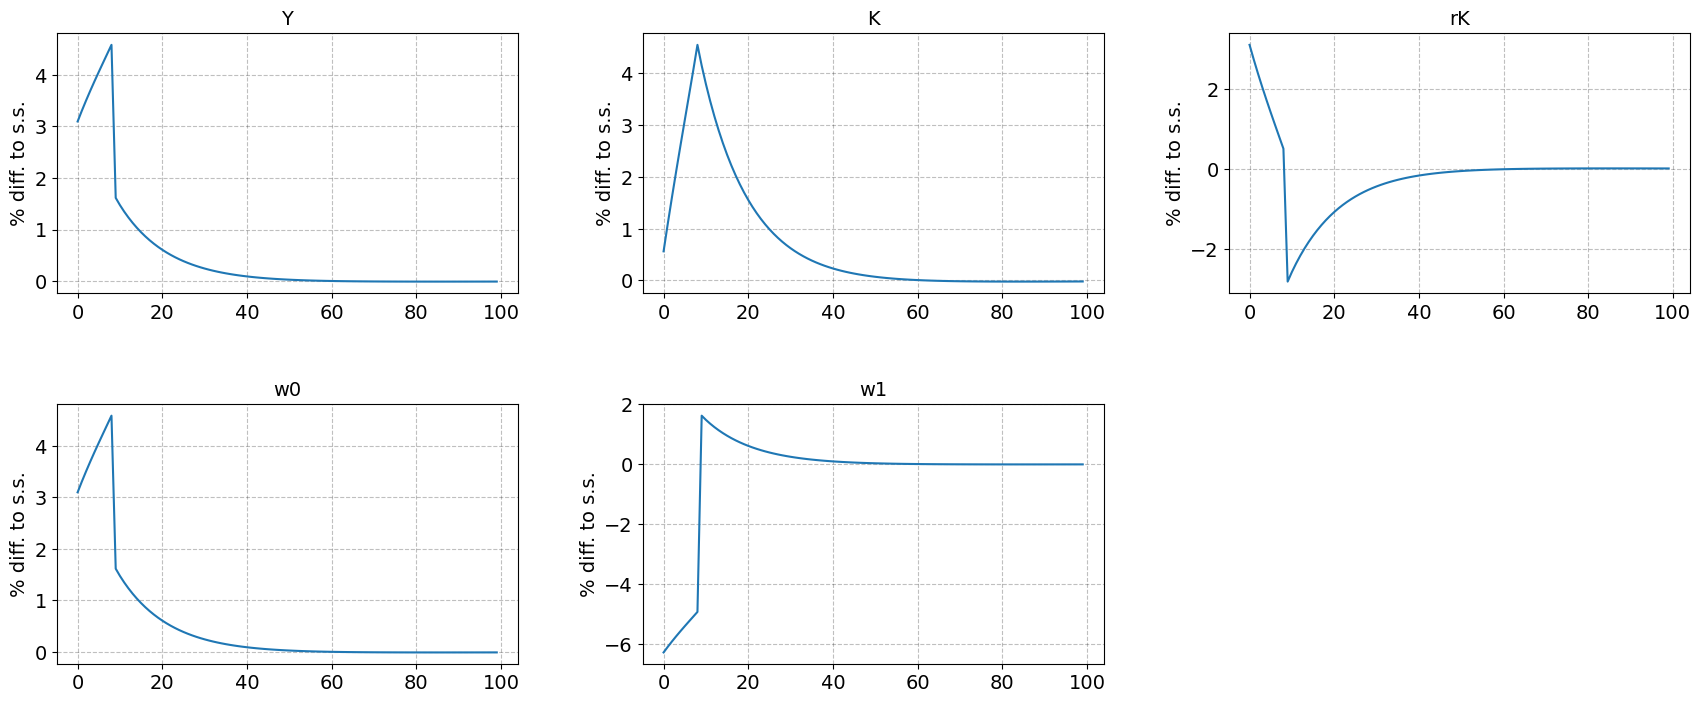


### tagets ###


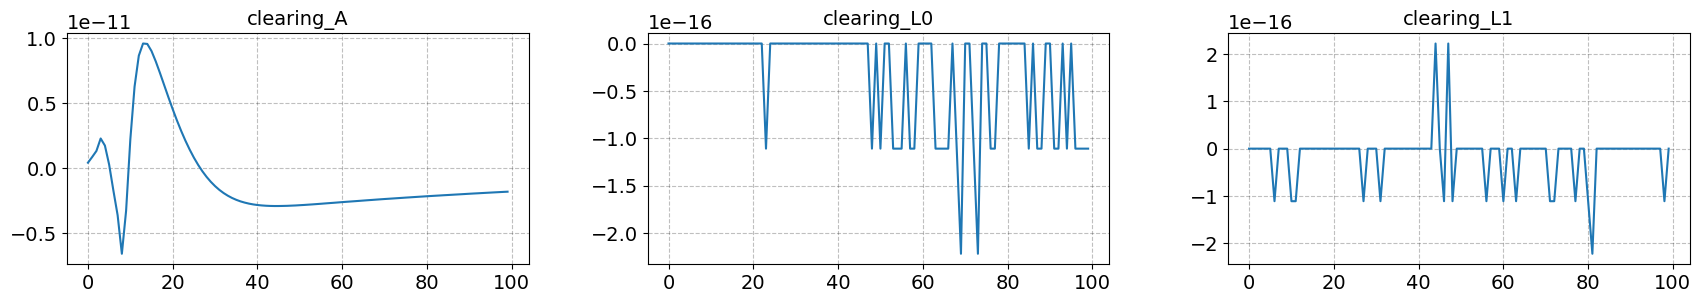

In [15]:
paths = ['Y','K','rK','w0','w1']
model.show_IRFs(paths,ncols=3,T_max=100)

### shocks ###


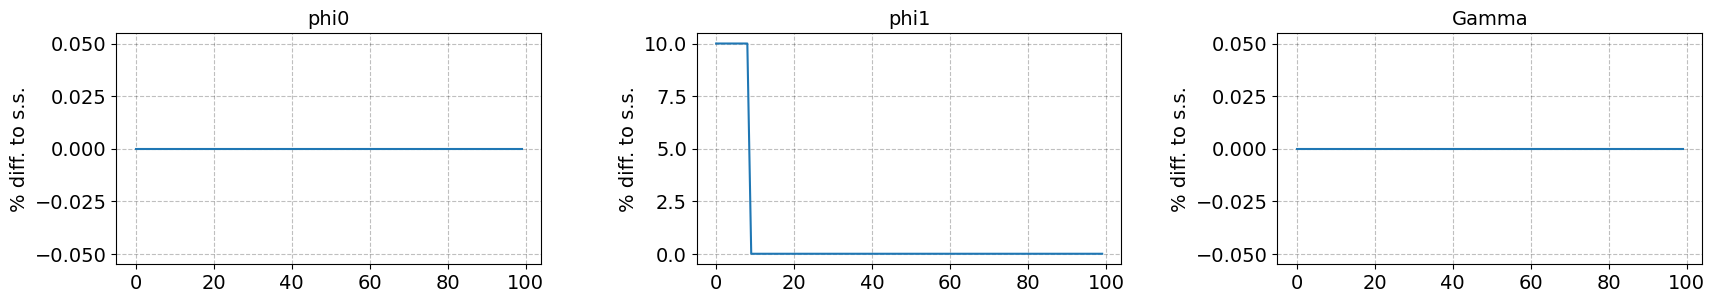


### varnames ###


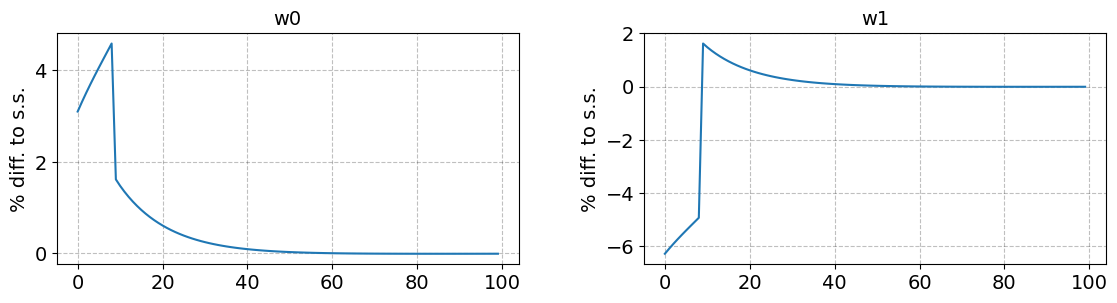


### tagets ###


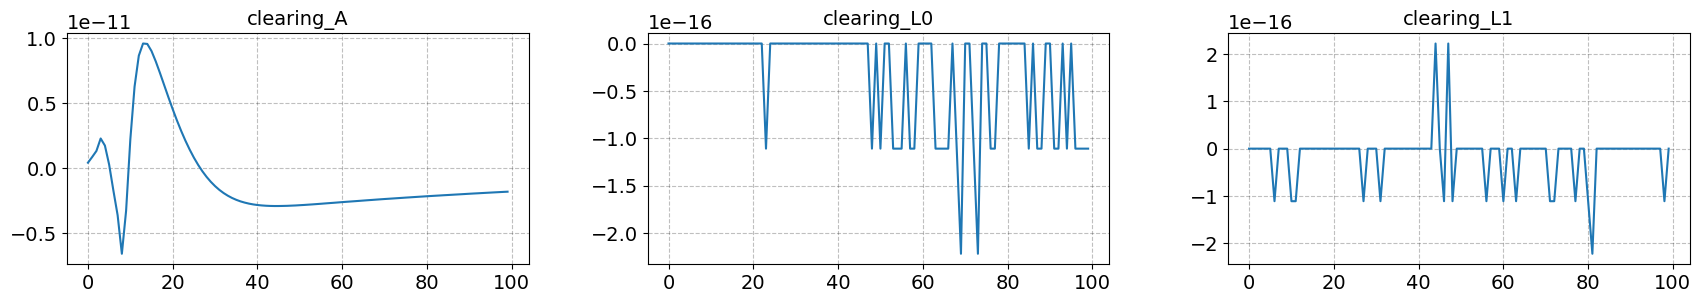

In [16]:
paths = ['w0','w1']
model.show_IRFs(paths,ncols=3,T_max=100)

## Transistion Path with a Permanent Shock

In [17]:
#setting initial values to old ss
ini = vars(model.ss)

#coping the model
modelII = model.copy()

In [18]:
ss = modelII.ss
ss.phi1 = 2.2

In [19]:
modelII.find_ss(method='direct',do_print=True)

### step 1: broad search ###

guess ss.K = 1.0000
implied ss.rK = 0.2863
implied ss.w0 = 0.3818
implied ss.w1 = 0.3471
household problem in ss solved in 0.3 secs [307 iterations]
household problem in ss simulated in 0.0 secs [89 iterations]
implied ss.A_hh = 205.4914
clearing_A = -204.49144701

guess ss.K = 2.0000
implied ss.rK = 0.1837
implied ss.w0 = 0.4900
implied ss.w1 = 0.4454
household problem in ss solved in 0.6 secs [570 iterations]
household problem in ss simulated in 0.0 secs [280 iterations]
implied ss.A_hh = 252.0377
clearing_A = -250.03768831

guess ss.K = 3.0000
implied ss.rK = 0.1417
implied ss.w0 = 0.5670
implied ss.w1 = 0.5154
household problem in ss solved in 0.9 secs [940 iterations]
household problem in ss simulated in 0.3 secs [2964 iterations]
implied ss.A_hh = 285.8369
clearing_A = -282.83692208

guess ss.K = 4.0000
implied ss.rK = 0.1179
implied ss.w0 = 0.6288
implied ss.w1 = 0.5717
household problem in ss solved in 1.5 secs [1544 iterations]
household problem i

In [20]:
for varname in modelII.varlist:
    print(f'{varname:15s}: {ss.__dict__[varname]:.4f}')

Gamma          : 1.0000
K              : 4.3103
phi0           : 1.0000
phi1           : 2.2000
L0             : 0.6667
L1             : 0.7333
rK             : 0.1124
w0             : 0.6460
w1             : 0.5872
Y              : 1.3458
A_hh           : 4.3103
C_hh           : 0.9147
U_hh           : -1.8082
L0_hh          : 0.6667
L1_hh          : 0.7333
A              : 4.3103
I              : 0.4310
clearing_A     : 0.0000
clearing_L0    : 0.0000
clearing_L1    : 0.0000
clearing_Y     : 0.0000


In [21]:
modelII.compute_jacs(do_print=True) # if skip_shocks = True the full Jacobians to shocks are not computed

household Jacobians:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for Gamma           in 0.7 secs
curly_Y and curly_D calculated for phi0            in 0.7 secs
curly_Y and curly_D calculated for phi1            in 0.7 secs
curly_Y and curly_D calculated for rK              in 0.7 secs
curly_Y and curly_D calculated for w0              in 0.7 secs
curly_Y and curly_D calculated for w1              in 0.7 secs
curly_E calculated in 0.2 secs
builiding blocks combined in 2.8 secs
household Jacobian computed in 7.1 secs

full Jacobians:
full Jacobian to unknowns computed in 0.9 secs [in evaluate_blocks(): 0.5 secs]
full Jacobian to shocks computed in 0.8 secs [in evaluate_blocks(): 0.5 secs]


In [22]:
# a. define shock
dphi1 = np.zeros(par.T)
dphi1[0] = -0.2
shocks = {'dphi1':dphi1} 

# b. find transition path
modelII.find_transition_path(do_print=True,shocks=shocks,ini=ini)

finding the transition path:
 it =   0 -> max. abs. error = 1.19e-01
   1.19e-01 in clearing_A
   2.39e-14 in clearing_L0
   6.67e-02 in clearing_L1
 it =   1 -> max. abs. error = 2.95e-04
   2.95e-04 in clearing_A
   5.55e-16 in clearing_L0
   7.33e-15 in clearing_L1
 it =   2 -> max. abs. error = 3.44e-06
   3.44e-06 in clearing_A
   3.33e-16 in clearing_L0
   5.55e-16 in clearing_L1
 it =   3 -> max. abs. error = 8.41e-09
   8.41e-09 in clearing_A
   5.55e-16 in clearing_L0
   4.44e-16 in clearing_L1
 it =   4 -> max. abs. error = 1.52e-11
   1.52e-11 in clearing_A
   3.33e-16 in clearing_L0
   4.44e-16 in clearing_L1

transition path found in 4.8 secs


### shocks ###


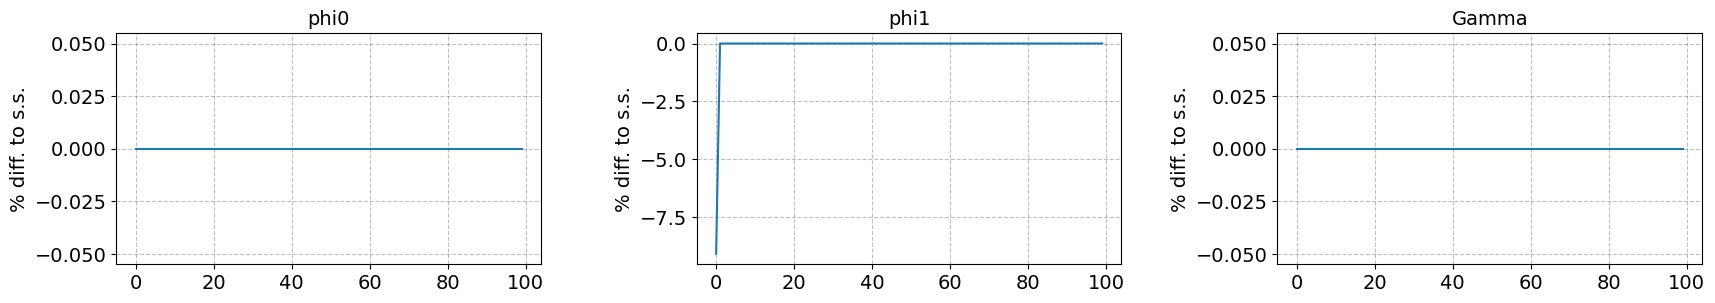


### varnames ###


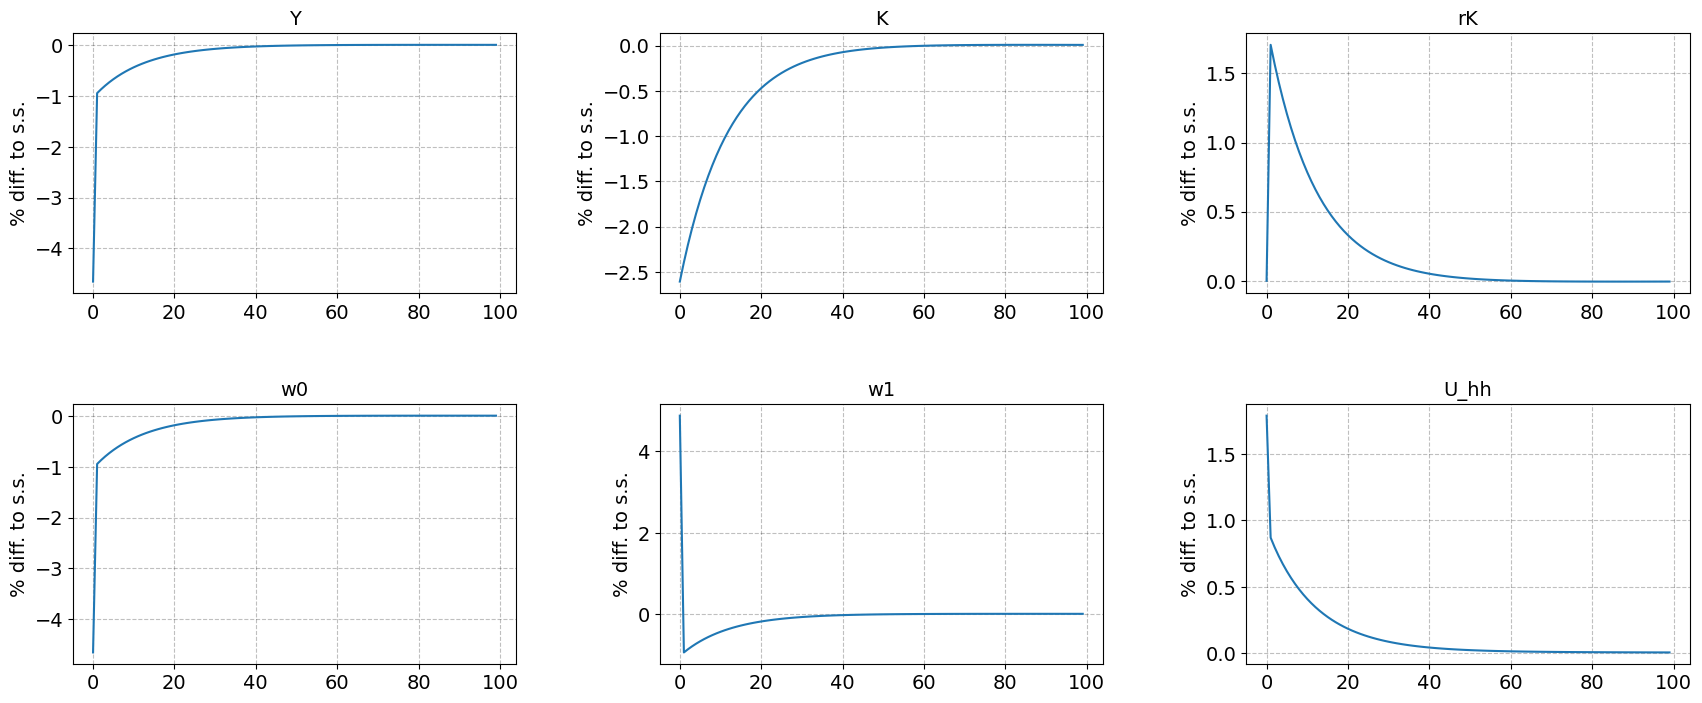


### tagets ###


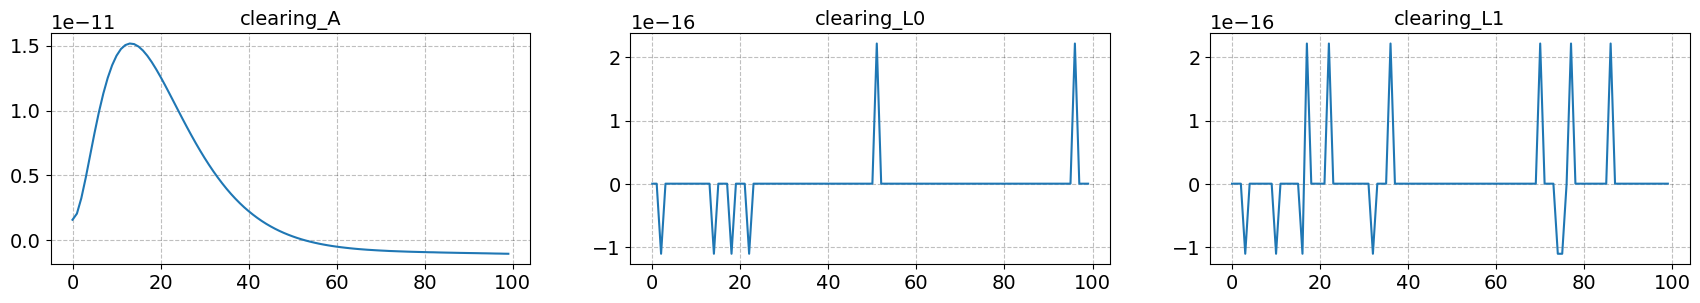

In [23]:
paths = ['Y','K','rK','w0','w1','U_hh']
modelII.show_IRFs(paths,ncols=3,T_max=100)

### shocks ###


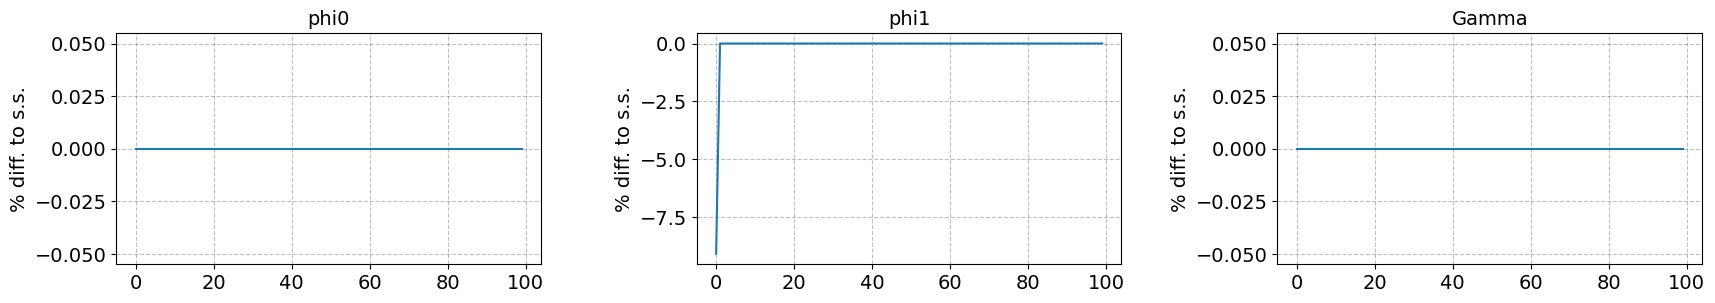


### varnames ###


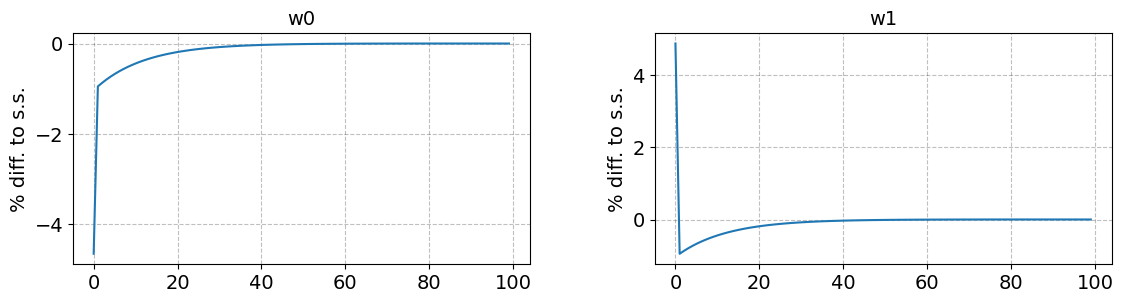


### tagets ###


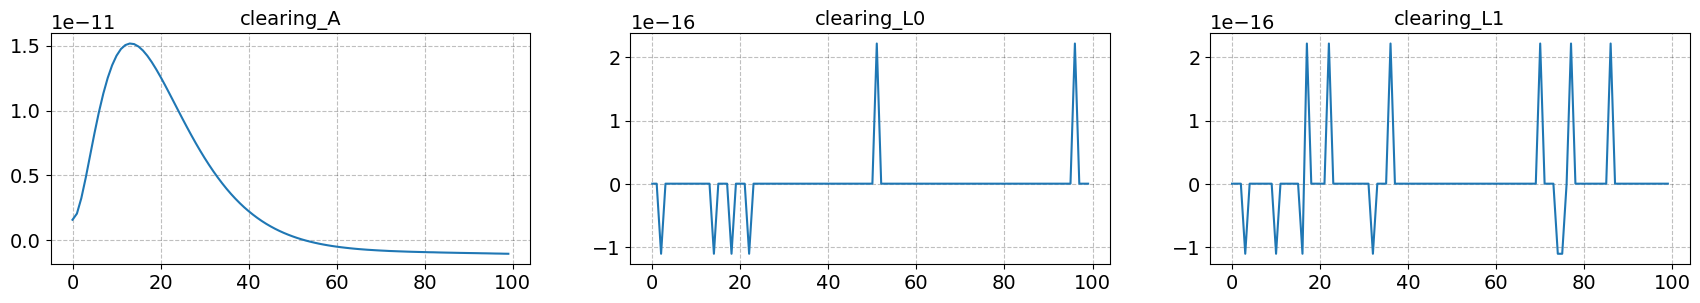

In [44]:
paths = ['w0','w1']
modelII.show_IRFs(paths,ncols=3,T_max=100)

In [40]:
for attr in ['u', 'c']:
    for i in range(2):
        setattr(modelII.path, f'{attr}{i}', np.zeros((par.T,1)))
        start, end = i * 3, (i + 1) * 3
        for t in range(par.T):
            weights = getattr(modelII.path, 'D')[t, start:end]
            values = getattr(modelII.path, attr)[t, start:end]
            getattr(modelII.path, f'{attr}{i}')[t] = np.average(values, weights=weights)

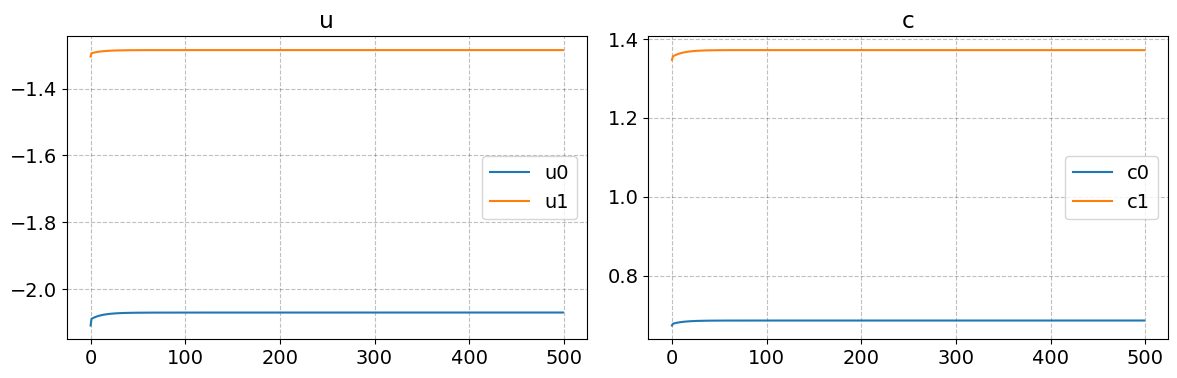

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4),dpi=100)

# Plot u
axs[0].plot(modelII.path.u0, label='u0')
axs[0].plot(modelII.path.u1, label='u1')
axs[0].set_title('u')
axs[0].legend()

# Plot c
axs[1].plot(modelII.path.c0, label='c0')
axs[1].plot(modelII.path.c1, label='c1')
axs[1].set_title('c')
axs[1].legend()

plt.tight_layout()
plt.show()

In [35]:
modelII.ss.u0 = np.zeros(par.T)
modelII.ss.u1 = np.zeros(par.T)

for 


modelII.ss.u

-1.8082333167567097